# Dataset Analysis Demo

This notebook demonstrates how to use the high-level analysis tooling from OG-MARL to inspect datasets.

In [1]:
from og_marl.vault_utils.download_vault import *
from og_marl.vault_utils.analyse_vault import *
from flashbax.vault import Vault
import jax
from og_marl.vault_utils.subsample_smaller import subsample_smaller_vault
from og_marl.vault_utils.subsample_similar import subsample_similar
from og_marl.vault_utils.combine_vaults import combine_vaults

## Download a vault and get to know the file structure
### OG-MARL vault file structure

In [2]:
print_download_options()

{'alberdice': {'rware': {'small-2ag': {...},
                         'small-4ag': {...},
                         'small-6ag': {...},
                         'tiny-2ag': {...},
                         'tiny-4ag': {...},
                         'tiny-6ag': {...}}},
 'cfcql': {'smac_v1': {'2s3z': {...},
                       '3s_vs_5z': {...},
                       '5m_vs_6m': {...},
                       '6h_vs_8z': {...}}},
 'og_marl': {'mamujoco': {'2halfcheetah': {...}},
             'smac_v1': {'2s3z': {...},
                         '3m': {...},
                         '3s5z_vs_3s6z': {...},
                         '5m_vs_6m': {...},
                         '8m': {...}},
             'smac_v2': {'terran_5_vs_5': {...}, 'zerg_5_vs_5': {...}}}}


We can either choose a source-environment-task combination from those available above, or we can specify our source-environment-task combination and input our own url for downloading the (zipped) vault.

In [3]:
source = 'og_marl'
env = 'smac_v1'
task = '2s3z'

rel_vault_location = download_and_unzip_vault(source,env,task)
_ = download_and_unzip_vault(source,env,'didi',dataset_download_url="dipidipidababa") #trying to download from a nonsense url will not work

Vault './vaults/og_marl/smac_v1/2s3z' already exists.
Dataset from dipidipidababa could not be downloaded. Try entering a different URL, or removing the part which auto-downloads.


We have now downloaded our vault into a folder ".vaults/{source}/{env}/{task}.vlt", if it didn't already exist. The vault may contain multiple datasets, each with a unique identifier, or UID.

In [4]:
print(rel_vault_location)
vault_uids = get_available_uids(rel_vault_location)
print(vault_uids)

./vaults/og_marl/smac_v1/2s3z.vlt
['Poor', 'Medium', 'Good']


So the folder ".vaults/og_marl/smac_v1/2s3z.vlt" contains a "Good", "Medium" and "Poor" dataset, each in their own folder.

### OG-MARL vault file structure to Vault file structure
The datasets from OG-MARL are placed in a file structure for maximum information retention about the dataset, which is why we talk about source, env, task and uid. Vault distinguishes only between three path components: the relative directory in which the vault sits, the vault name, and the vault uid.

In [5]:
vault_rel_dir = f"vaults/{source}/{env}" # combine base vault directory with the dataset source and environment folders
vault_name = f"{task}.vlt" # a vault name contains only the file name which has the .vlt extension
vault_uid = vault_uids[0] # we select the first dataset in the vault

vlt = Vault(rel_dir=vault_rel_dir, vault_name=vault_name, vault_uid=vault_uid)

Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Poor


For further information about a Vault's api, please see the dataset api demo.

## Subsample a vault
OG-MARL provides tooling for subsampling a vault, in the case where working with a large vault is intractable, or if you just want a smaller vault. This *creates a new vault* so keep an eye on your storage when making lots of subsampled vaults.

#### Uniformly subsampling episodes to a desired number of transitions
We uniformly subsample episodes to within an episode of the desired number of transitions (this is to avoid subsampling partial episodes, since we often work with episode returns of a dataset and a partial episode provides an inaccurate return value).

If you try to subsample an amount of transitions greater than the contents of the vault, this function will simply return a copy of the vault with the episodes shuffled, which is a potential if inefficient use case of this function.

First, we see how big a dataset is.

In [6]:
all_data = vlt.read()
offline_data = all_data.experience
jax.tree_map(lambda x: x.shape, offline_data)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


{'actions': (1, 996418, 5),
 'infos': {'legals': (1, 996418, 5, 11), 'state': (1, 996418, 120)},
 'observations': (1, 996418, 5, 80),
 'rewards': (1, 996418, 5),
 'terminals': (1, 996418, 5),
 'truncations': (1, 996418, 5)}

Now that we know how many transitions are in the dataset (the second value), we can make a good choice of size for subsampling.

Vault 'vaults/og_marl/smac_v1/2s3z_20000' already exists. To subsample from scratch, please remove the current subsampled vault from its directory.
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z_20000.vlt/Poor
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z_20000.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z_20000.vlt/Good
Uid         Mean    Stddev    Min return    Max return    Transitions    Trajectories    Joint SACo
------  --------  --------  ------------  ------------  -------------  --------------  ------------
Poor     6.74365   2.11073       1.88235       12.4902          19997             201      0.950343
Medium  12.7193    3.26011       5.78431       20.402           19969             364      0.991437
Good    18.1634    3.1373        8.28922       20.3971          19989             376      0.989344


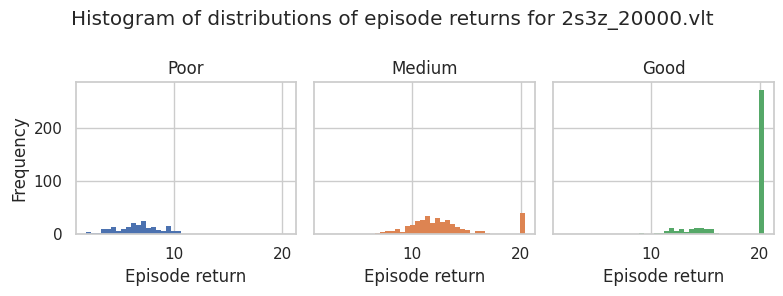

In [7]:
n_transitions = 20000

# we can specify a list with just one uid to subsample only one, but automatically it subsamples each dataset in the vault
new_vault_name = subsample_smaller_vault(vault_rel_dir,vault_name,target_number_of_transitions=n_transitions)

new_vault_name = task+'_'+str(n_transitions)+'.vlt'

returns = descriptive_summary(vault_name=new_vault_name, rel_dir=vault_rel_dir,save_hist=True)

### Subsampling two vaults to have similar episode return  distributions

We also have utility to subsample two vaults so that their episode return distributions are as similar as possible. The result should have a episode return distributions that look like the intersection of the original distributions.

For the original "2s3z" vaults, we see that there is overlap between the "Medium" and "Good" vaults. Let's try to subsample them similarly.

Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Good
New vault created at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z_similarly_subsampled.vlt/Medium
Since the provided buffer state has a temporal dimension of 500000, you must write to the vault at least every 499999 timesteps to avoid data loss.
392204
New vault created at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z_similarly_subsampled.vlt/Good
Since the provided buffer state has a temporal dimension of 500000, you must write to the vault at least every 499999 timesteps to avoid data loss.
371176
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z_similarly_subsampled.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z_similarly_subsampled.vlt/Good
Uid 

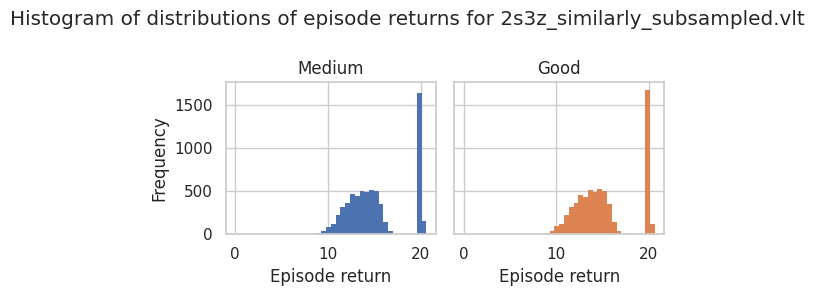

In [14]:
medium_vault_info = {
    "rel_dir": vault_rel_dir,
    "vault_name":vault_name,
    "uid": 'Medium',
}
good_vault_info = {
    "rel_dir": vault_rel_dir,
    "vault_name":vault_name,
    "uid": 'Good',
}

subsampled_vault_name = f"{task}_similarly_subsampled.vlt"
# we can specify a list with just one uid to subsample only one, but automatically it subsamples each dataset in the vault
subsample_similar(medium_vault_info,good_vault_info,vault_rel_dir,subsampled_vault_name)

returns = descriptive_summary(vault_name=subsampled_vault_name, rel_dir=vault_rel_dir,save_hist=True)

### Combine datasets in a vault

We present utilities to combine datasets within a vault. To test, we combine the smaller subsampled vaults.

Vault 'vaults/og_marl/smac_v1/2s3z_20000_combined' already exists. To combine from scratch, please remove the current combined vault from its directory.
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z_20000_combined.vlt/Poor_Medium_Good
Uid                  Mean    Stddev    Min return    Max return    Transitions    Trajectories    Joint SACo
----------------  -------  --------  ------------  ------------  -------------  --------------  ------------
Poor_Medium_Good  13.6182   5.25907       1.88235        20.402          59955             941      0.975982


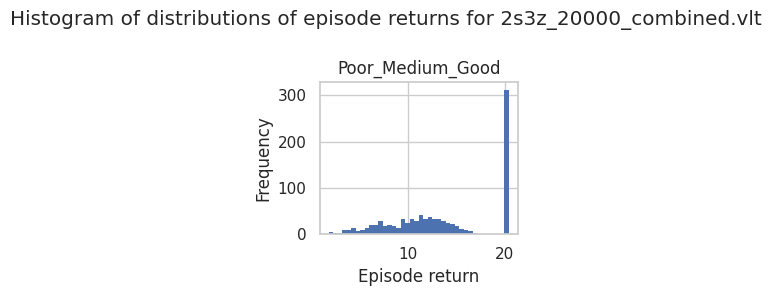

In [9]:
comb_vault_name = combine_vaults(vault_rel_dir,new_vault_name)

comb_vault_name = f"{new_vault_name.strip('.vlt')}_combined.vlt"

returns = descriptive_summary(vault_name=comb_vault_name, rel_dir=vault_rel_dir,save_hist=True)

## Vault analysis

The analysis tool we have been using so far is a summary, the goal of which is to give a quick overview of a dataset's episode returns to verify that subsampling worked as it should.

We do, however, provide more extensive tools for analysis, particularly, to describe the structure, episode returns and coverage of a dataset.

Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Poor
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Good
Uid         Mean    Stddev    Min return    Max return    Transitions    Trajectories    Joint SACo
------  --------  --------  ------------  ------------  -------------  --------------  ------------
Poor     6.87636   2.06233             0       13.6128         996418            9942      0.960472
Medium  12.567     3.14207             0       21.299          996256           18605      0.98416
Good    18.3202    2.95182             0       21.6225         995829           18616      0.984996


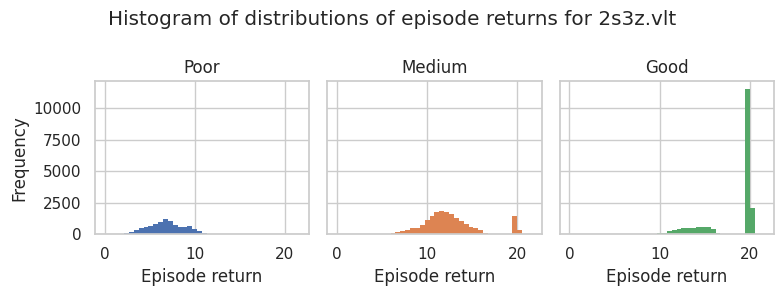

In [10]:
returns = descriptive_summary(vault_name, vault_uids,vault_rel_dir, save_hist=True)

In [11]:
heads = describe_structure(vault_name, vault_uids,vault_rel_dir)

Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Poor
Poor
-----
actions:        (1, 996418, 5)
infos:         {'legals': (1, 996418, 5, 11), 'state': (1, 996418, 120)}
observations:  (1, 996418, 5, 80)
rewards:        (1, 996418, 5)
terminals:      (1, 996418, 5)
truncations:    (1, 996418, 5)


Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Medium
Medium
-----
actions:        (1, 996256, 5)
infos:         {'legals': (1, 996256, 5, 11), 'state': (1, 996256, 120)}
observations:  (1, 996256, 5, 80)
rewards:        (1, 996256, 5)
terminals:      (1, 996256, 5)
truncations:    (1, 996256, 5)


Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Good
Good
-----
actions:        (1, 995829, 5)
infos:         {'legals': (1, 995829, 5, 11), 'state': (1, 995829, 120)}
observations:  (1, 995829, 5, 80)
rewards:        (1, 995829, 5)
terminals:      (1, 995829, 

Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Poor
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Good
Uid         Mean    Stddev      Max    Min
------  --------  --------  -------  -----
Poor     6.87636   2.06233  13.6128      0
Medium  12.567     3.14207  21.299       0
Good    18.3202    2.95182  21.6225      0


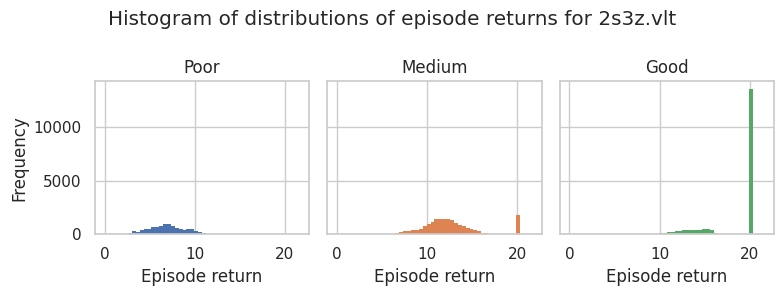

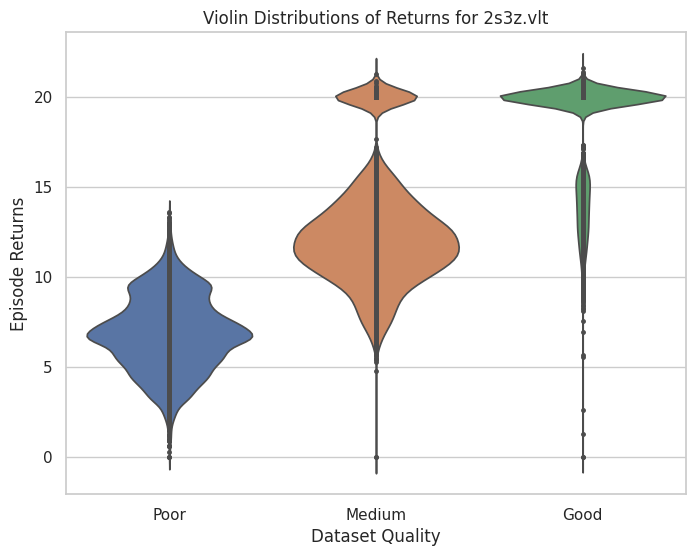

In [12]:
describe_episode_returns(vault_name, vault_uids,vault_rel_dir)

Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Poor
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Good
Uid       Joint SACo
------  ------------
Poor        0.960472
Medium      0.98416
Good        0.984996


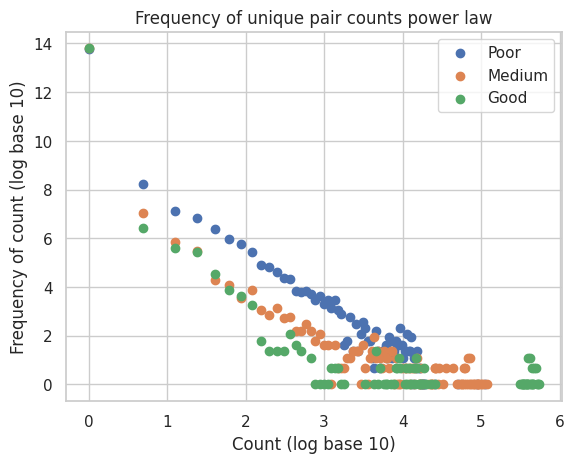

In [13]:
describe_coverage(vault_name, vault_uids,vault_rel_dir)